In [1]:
import pandas as pd
import numpy as np

def load_stock_data(filename):
    # Reads the file (it can be tab or comma separated, adjust sep if needed)
    df = pd.read_csv(filename, sep=None, engine='python')

    # Clean column names (remove spaces and fix case)
    df.columns = [col.strip().capitalize() for col in df.columns]

    # Parse 'Time' column as datetime
    df['Datetime'] = pd.to_datetime(df['Time'])
    df.drop(columns=['Time', 'Volume'], inplace=True)

    # Set as index and sort
    df.set_index('Datetime', inplace=True)
    df.sort_index(inplace=True)


    return df

# Example usage
df = load_stock_data('EURUSD_15m_BID_01.01.2010-31.12.2016.csv')
print(df.head())

                        Open     High      Low    Close
Datetime                                               
2010-01-01 00:00:00  1.43283  1.43293  1.43224  1.43293
2010-01-01 00:15:00  1.43285  1.43295  1.43229  1.43275
2010-01-01 00:30:00  1.43280  1.43303  1.43239  1.43281
2010-01-01 00:45:00  1.43285  1.43294  1.43229  1.43276
2010-01-01 01:00:00  1.43287  1.43292  1.43206  1.43282


##### 2019-01-01 and 2019-04-30 4 hour data

c:\Users\user\miniconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


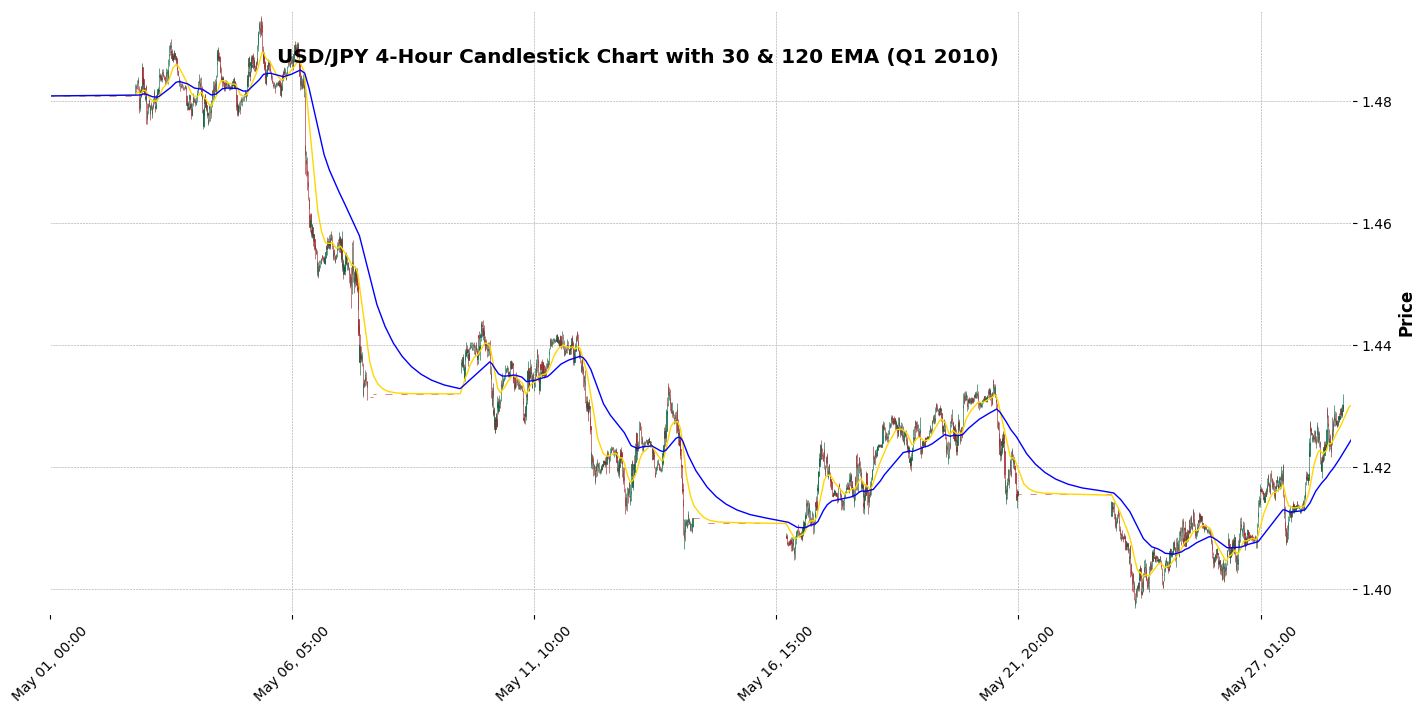

In [2]:
import pandas as pd
import mplfinance as mpf

# Filter 2019 Q1 using datetime index
df_2019_q1 = df[(df.index >= '2011-05-01') & (df.index <= '2011-05-29')].copy()

"""  
# Resample to 4-hour intervals
df_4h = df_2019_q1.resample('4H').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
}).dropna()

"""
df_4h = df_2019_q1.copy()

# Calculate 30 and 120 period EMAs on 'Close'
df_4h['EMA_30'] = df_4h['Close'].ewm(span=30, adjust=False).mean()
df_4h['EMA_120'] = df_4h['Close'].ewm(span=120, adjust=False).mean()

df_4h['trend'] = np.where(df_4h['EMA_30'] > df_4h['EMA_120'], 'bullish', 
                    np.where(df_4h['EMA_30'] < df_4h['EMA_120'],'bearish', np.nan))
df_4h["Green"] = np.select(
    [df_4h["Close"] > df_4h["Open"], df_4h["Close"] < df_4h["Open"]],
    [True, False],
    default=pd.NA
).astype("object")  # <- 'boolean' not 'bool'
df["label"] = None
df["label"] = df["label"].astype(object)

# Plot candlestick chart with EMAs
mpf.plot(df_4h[['Open', 'High', 'Low', 'Close']],
         type='candle',
         style='charles',
         title='USD/JPY 4-Hour Candlestick Chart with 30 & 120 EMA (Q1 2010)',
         ylabel='Price',
         volume=False,
         figsize=(15, 7),
         tight_layout=True,
         addplot=[
             mpf.make_addplot(df_4h['EMA_30'], color='gold', width=1),
             mpf.make_addplot(df_4h['EMA_120'], color='blue', width=1)
         ])


#### Fib

In [3]:
print(df_4h[0:])

                        Open     High      Low    Close    EMA_30   EMA_120  \
Datetime                                                                      
2011-05-01 00:00:00  1.48084  1.48084  1.48084  1.48084  1.480840  1.480840   
2011-05-01 00:15:00  1.48084  1.48084  1.48084  1.48084  1.480840  1.480840   
2011-05-01 00:30:00  1.48084  1.48084  1.48084  1.48084  1.480840  1.480840   
2011-05-01 00:45:00  1.48084  1.48084  1.48084  1.48084  1.480840  1.480840   
2011-05-01 01:00:00  1.48084  1.48084  1.48084  1.48084  1.480840  1.480840   
...                      ...      ...      ...      ...       ...       ...   
2011-05-28 23:00:00  1.43093  1.43093  1.43093  1.43093  1.429962  1.424187   
2011-05-28 23:15:00  1.43093  1.43093  1.43093  1.43093  1.430024  1.424299   
2011-05-28 23:30:00  1.43093  1.43093  1.43093  1.43093  1.430083  1.424408   
2011-05-28 23:45:00  1.43093  1.43093  1.43093  1.43093  1.430137  1.424516   
2011-05-29 00:00:00  1.43093  1.43093  1.43093  1.43

In [4]:
print(df_4h.columns)


Index(['Open', 'High', 'Low', 'Close', 'EMA_30', 'EMA_120', 'trend', 'Green'], dtype='object')


In [16]:
import matplotlib.patches as patches

def plot_fibonacci_candlestick(df, start_idx, end_idx, levels=None, trend="bearish", entry_signal=None, engulfing_candle=None, R=None, pip_size=0.0010,plot_until_idx=None):

    if levels is None:
        levels = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

    df_slice = df.iloc[start_idx:end_idx + 2 + 1].copy()
    min_price = df_slice['Low'].min()
    max_price = df_slice['High'].max()

    fib_lines = []
    fib_labels = []

    for level in levels:
        if trend == "bearish":
            y = min_price + (max_price - min_price) * level
        else:
            y = max_price - (max_price - min_price) * level

        line_data = [np.nan] * len(df)
        line_data[start_idx:end_idx + 1] = [y] * (end_idx - start_idx + 1)

        fib_lines.append(mpf.make_addplot(
            line_data,
            color='gray', linestyle='--', width=0.7
        ))

        fib_labels.append((level, y))

    # Add EMAs
    ema_30_plot = mpf.make_addplot(df['EMA_30'], color='gold', width=1.2, panel=0)
    ema_120_plot = mpf.make_addplot(df['EMA_120'], color='blue', width=1.2, panel=0)

    all_addplots = fib_lines + [ema_30_plot, ema_120_plot]

    # Entry Signal
    if entry_signal is not None and 0 <= entry_signal < len(df):
        entry_price = df['Close'].iloc[entry_signal]
        marker = '^' if trend == "bullish" else 'v'
        color = 'green' if trend == "bullish" else 'red'
        signal_plot = mpf.make_addplot(
            [entry_price if i == entry_signal else np.nan for i in range(len(df))],
            type='scatter',
            markersize=100,
            marker=marker,
            color=color
        )
        all_addplots.append(signal_plot)
    
    # Determine plotting range
    plot_buffer = 30
    extra_right = 20  # Show 10 bars after the trade exit for context

    plot_start = max(0, start_idx - plot_buffer)
    if plot_until_idx is not None:
        plot_end = min(len(df) - 1, plot_until_idx + extra_right)
    else:
        plot_end = min(len(df) - 1, end_idx + plot_buffer + 20)

    # Slice local region for plotting and Y-axis range
    df_slice_plot = df.iloc[plot_start:plot_end + 1].copy()

    # Plot candlestick chart first
    fig, axlist = mpf.plot(df,
                           type='candle',
                           style='yahoo',
                           addplot=all_addplots,
                           title='Fibonacci Retracement with EMA and Reward Box',
                           ylabel='Price',
                           volume=False,
                           returnfig=True,
                           warn_too_much_data=10000)

    ax = axlist[0]
    # ✅ Set local X-axis limits (index range)
    ax.set_xlim(plot_start, plot_end)

    # ✅ Set local Y-axis limits (based on High/Low in local range)
    local_min = df_slice_plot['Low'].min()
    local_max = df_slice_plot['High'].max()

    box_y_min = local_min
    box_y_max = local_max

    if R is not None and engulfing_candle is not None:
        candle = df.iloc[engulfing_candle]
        close_price = candle['Close']

        if trend == "bearish":
            risk_min = min(close_price, close_price + pip_size)
            reward_min = close_price - R * pip_size
            box_y_min = min(box_y_min, risk_min, reward_min)
            risk_max = max(close_price, close_price + pip_size)
            reward_max = close_price
            box_y_max = max(box_y_max, risk_max, reward_max)
        else:  # bullish
            risk_min = close_price - pip_size
            reward_min = min(close_price, close_price + R * pip_size)
            box_y_min = min(box_y_min, risk_min, reward_min)
            risk_max = close_price
            reward_max = max(close_price, close_price + R * pip_size)
            box_y_max = max(box_y_max, risk_max, reward_max)

    # Now add padding to the new y-limits
    price_padding = 0.1 * (box_y_max - box_y_min)
    ax.set_ylim(box_y_min - price_padding, box_y_max + price_padding)

    # ✅ Reward box drawing only if engulfing_candle is not None
    if R is not None and engulfing_candle is not None:
        candle = df.iloc[engulfing_candle]
        close_price = candle['Close']

        # Box width (horizontal span)
        if plot_until_idx is not None and plot_until_idx > engulfing_candle:
            box_left = engulfing_candle
            box_right = plot_until_idx 
        else:
            box_left = engulfing_candle
            box_right = engulfing_candle + 10  # fallback to default width if not specified

        width = box_right - box_left + 1  # +1 to include both ends

        if trend == "bearish":
            # --- Red Box (Risk area) ---
            red_top = close_price + pip_size
            red_bottom = close_price
            red_height = abs(red_top - red_bottom)
            red_y = min(red_top, red_bottom)

            red_box = patches.Rectangle(
                (box_left, red_y),
                width,
                red_height,
                linewidth=0,
                edgecolor=None,
                facecolor='red',
                alpha=0.3,
                zorder=0
            )
            ax.add_patch(red_box)

            # --- Green Box (Reward area) ---
            green_top = close_price
            green_bottom = close_price - R * pip_size
            green_height = abs(green_top - green_bottom)
            green_y = min(green_top, green_bottom)

            green_box = patches.Rectangle(
                (box_left, green_y),
                width,
                green_height,
                linewidth=0,
                edgecolor=None,
                facecolor='green',
                alpha=0.3,
                zorder=0
            )
            ax.add_patch(green_box)

        else:  # trend == "bullish"
            # --- Red Box (Risk area) ---
            red_top = close_price
            red_bottom = close_price - pip_size
            red_height = abs(red_top - red_bottom)
            red_y = min(red_top, red_bottom)

            red_box = patches.Rectangle(
                (box_left, red_y),
                width,
                red_height,
                linewidth=0,
                edgecolor=None,
                facecolor='red',
                alpha=0.3,
                zorder=0
            )
            ax.add_patch(red_box)

            # --- Green Box (Reward area) ---
            green_top = close_price
            green_bottom = close_price + R * pip_size
            green_height = abs(green_top - green_bottom)
            green_y = min(green_top, green_bottom)

            green_box = patches.Rectangle(
                (box_left, green_y),
                width,
                green_height,
                linewidth=0,
                edgecolor=None,
                facecolor='green',
                alpha=0.3,
                zorder=0
            )
            ax.add_patch(green_box)
    

    # Annotate Fib levels
    for level, y in fib_labels:
        label_text = f"{level:.3f}"
        ax.annotate(label_text,
                    xy=(end_idx, y),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left',
                    va='center',
                    fontsize=8,
                    color='gray')
    
    # 🔍 Annotate any labels in the df['label'] column
    for i in range(plot_start, plot_end + 1):
        label = df['label'].iloc[i]
        if pd.notna(label) and str(label).strip() != "":
            y = df['High'].iloc[i] + 0.5 * price_padding  # Place label above the candle
            ax.annotate(str(label),
                        xy=(i, y),
                        xytext=(0, 0),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        color='black',
                        rotation=0)

    stop_loss_price = None
    take_profit_price = None

    if R is not None and engulfing_candle is not None:
        candle = df.iloc[engulfing_candle]
        close_price = candle['Close']

        if trend == "bearish":
            stop_loss_price = close_price + pip_size
            take_profit_price = close_price - R * pip_size
        else:  # bullish
            stop_loss_price = close_price - pip_size
            take_profit_price = close_price + R * pip_size

    plt.show()
    return stop_loss_price, take_profit_price, fib_labels


##### Detect peak / trough

[2011-05-02 20:00:00] Trend changed from nan to bullish, reset state to IDLE
self.trend_changing_idx 176
[2011-05-02 22:00:00] State: IDLE → PULLBACK_DETECTED (bull)
[2011-05-02 23:30:00] State: PULLBACK_DETECTED → BREAK_OF_STRUCTURE (bull)
[2011-05-03 01:45:00] State: BREAK_OF_STRUCTURE → PULLBACK_DETECTED (bull)
[2011-05-03 02:15:00] Trend changed from bullish to bearish, reset state to IDLE
self.trend_changing_idx 201
[2011-05-03 07:00:00] State changed: IDLE → PULLBACK_DETECTED
[2011-05-03 08:30:00] Trend changed from bearish to bullish, reset state to IDLE
self.trend_changing_idx 226
[2011-05-03 10:45:00] State: IDLE → PULLBACK_DETECTED (bull)
[2011-05-03 13:00:00] State: PULLBACK_DETECTED → BREAK_OF_STRUCTURE (bull)
self.df.index[self.high_price_idx]: 2011-05-03 14:00:00


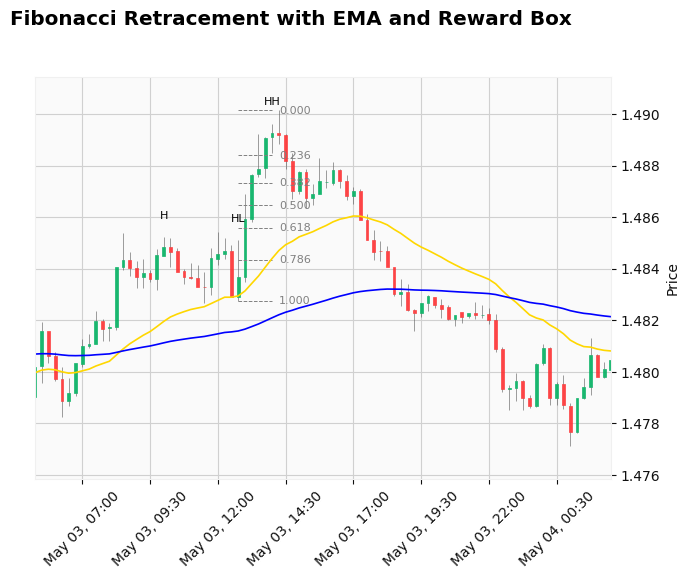

[2011-05-03 14:45:00] State: BREAK_OF_STRUCTURE → WAITING_ENTRY (bull)


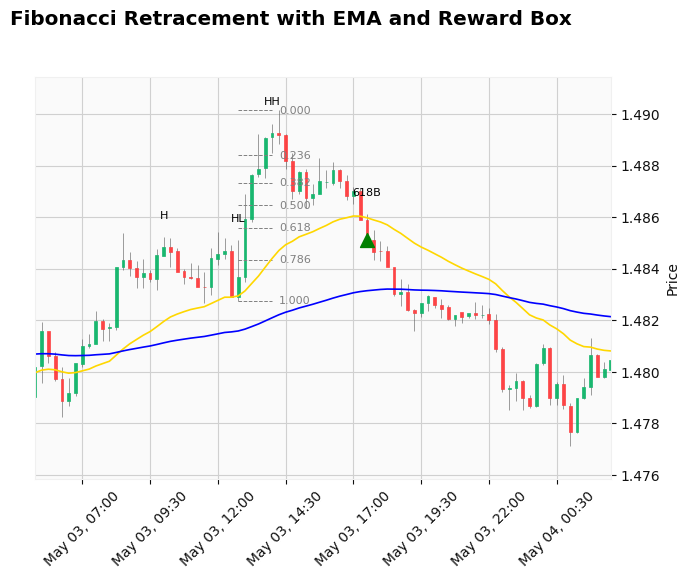

[2011-05-03 17:30:00] State: WAITING_ENTRY → ENTRY_SIGNAL (bull)
[2011-05-03 19:00:00] State: ENTRY_SIGNAL → PULLBACK_DETECTED (bull)
[2011-05-03 23:00:00] Trend changed from bullish to bearish, reset state to IDLE
self.trend_changing_idx 284
[2011-05-04 01:45:00] State changed: IDLE → PULLBACK_DETECTED
[2011-05-04 07:00:00] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE


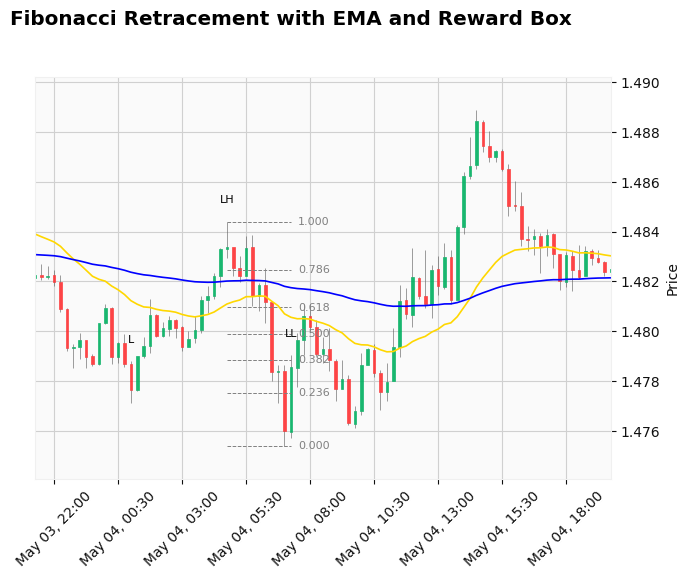

[2011-05-04 07:45:00] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY


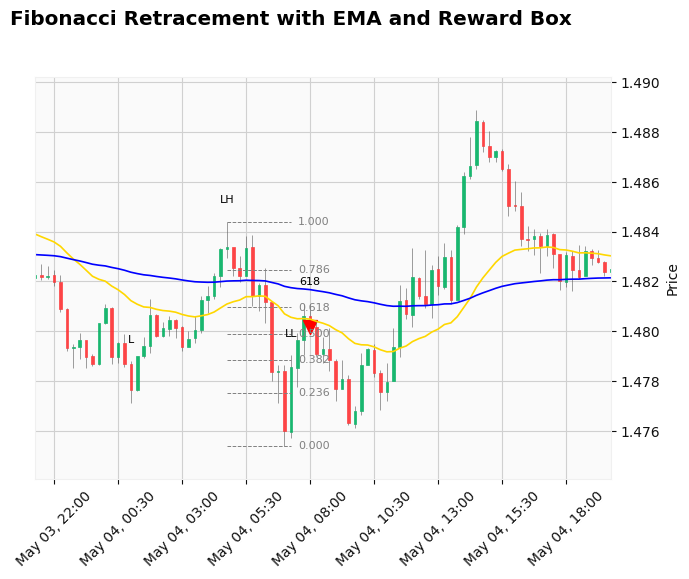

[2011-05-04 08:00:00] State changed: WAITING_ENTRY → ENTRY_SIGNAL


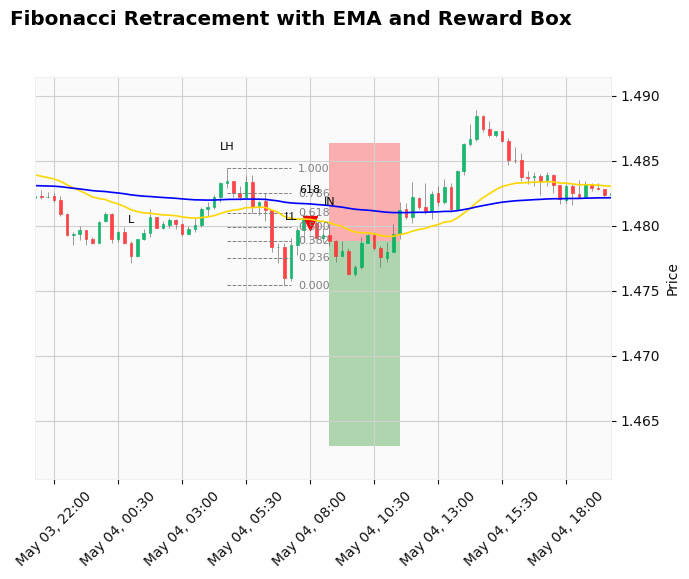

[2011-05-04 08:45:00] State changed: ENTRY_SIGNAL → ENTER_MARKET


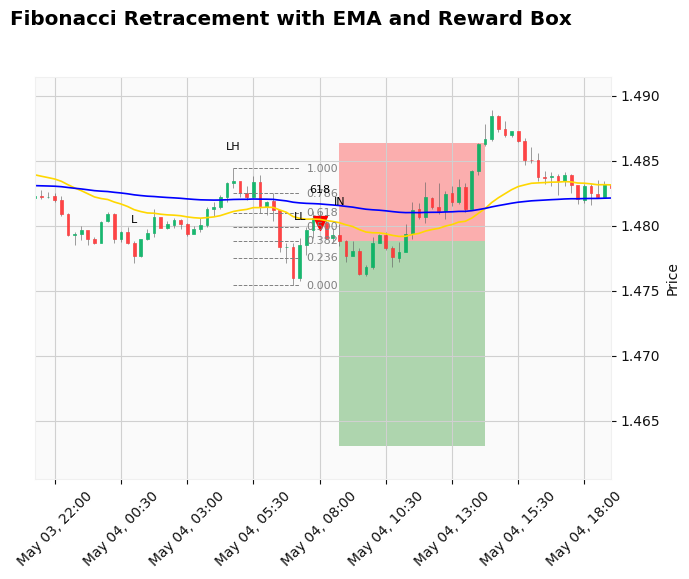

[2011-05-04 14:00:00] STOP LOSS triggered at price 1.48639
[2011-05-04 14:00:00] Exited ENTER_MARKET — resetting FSM to IDLE
[2011-05-04 14:15:00] State changed: IDLE → PULLBACK_DETECTED
[2011-05-04 14:30:00] Trend changed from bearish to bullish, reset state to IDLE
self.trend_changing_idx 346
[2011-05-04 16:00:00] State: IDLE → PULLBACK_DETECTED (bull)
[2011-05-05 00:45:00] Trend changed from bullish to bearish, reset state to IDLE
self.trend_changing_idx 387
[2011-05-05 04:30:00] State changed: IDLE → PULLBACK_DETECTED
[2011-05-05 06:30:00] Trend changed from bearish to bullish, reset state to IDLE
self.trend_changing_idx 410
[2011-05-05 09:00:00] State: IDLE → PULLBACK_DETECTED (bull)
[2011-05-05 11:00:00] State: PULLBACK_DETECTED → BREAK_OF_STRUCTURE (bull)
self.df.index[self.high_price_idx]: 2011-05-05 12:45:00


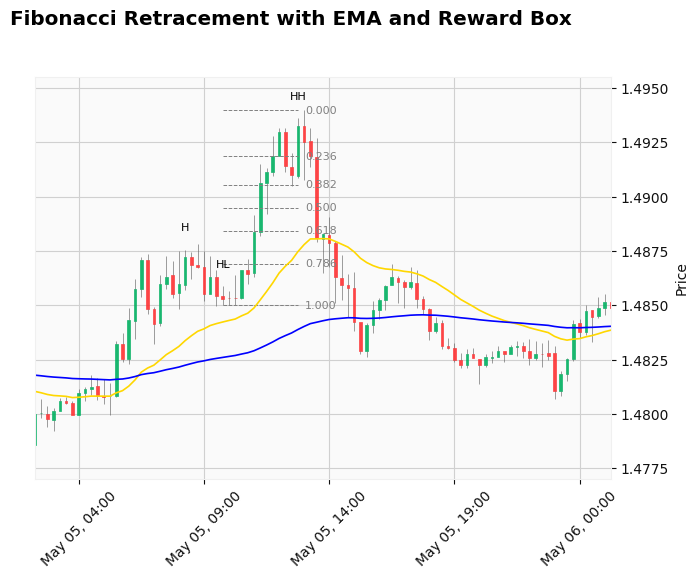

[2011-05-05 13:30:00] State: BREAK_OF_STRUCTURE → WAITING_ENTRY (bull)


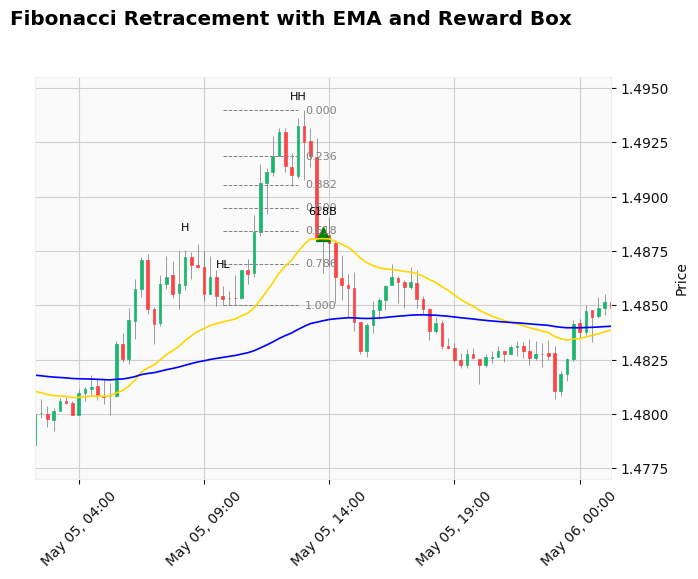

[2011-05-05 13:45:00] State: WAITING_ENTRY → ENTRY_SIGNAL (bull)
[2011-05-05 15:00:00] State: ENTRY_SIGNAL → PULLBACK_DETECTED (bull)
[2011-05-05 21:30:00] Trend changed from bullish to bearish, reset state to IDLE
self.trend_changing_idx 470
[2011-05-05 23:45:00] State changed: IDLE → PULLBACK_DETECTED
[2011-05-06 02:30:00] Trend changed from bearish to bullish, reset state to IDLE
self.trend_changing_idx 490
[2011-05-06 07:15:00] State: IDLE → PULLBACK_DETECTED (bull)
[2011-05-06 07:45:00] State: PULLBACK_DETECTED → BREAK_OF_STRUCTURE (bull)
[2011-05-06 08:30:00] State: BREAK_OF_STRUCTURE → PULLBACK_DETECTED (bull)
[2011-05-06 11:15:00] Trend changed from bullish to bearish, reset state to IDLE
self.trend_changing_idx 525
[2011-05-06 19:30:00] State changed: IDLE → PULLBACK_DETECTED
[2011-05-07 10:30:00] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE
[2011-05-09 20:45:00] Trend changed from bearish to bullish, reset state to IDLE
self.trend_changing_idx 851
[2011-05-09 21:45:0

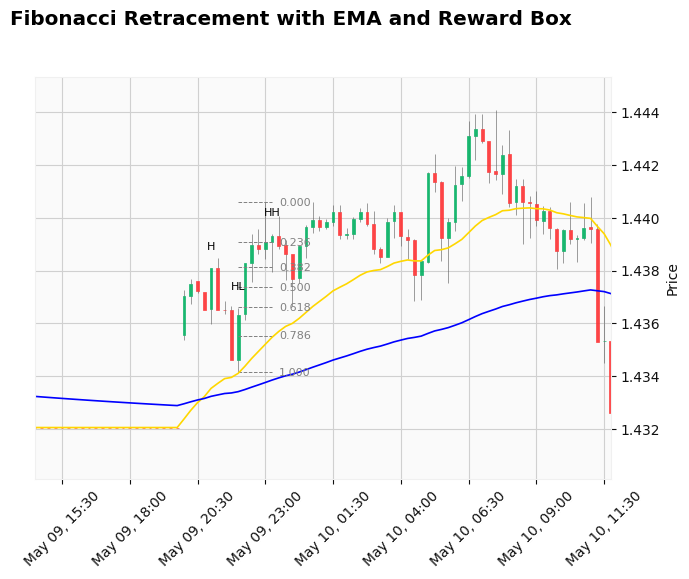

[2011-05-10 00:00:00] State: BREAK_OF_STRUCTURE → WAITING_ENTRY (bull)
[2011-05-10 05:00:00] State: WAITING_ENTRY → BREAK_OF_STRUCTURE (bull)
self.df.index[self.high_price_idx]: 2011-05-10 06:45:00


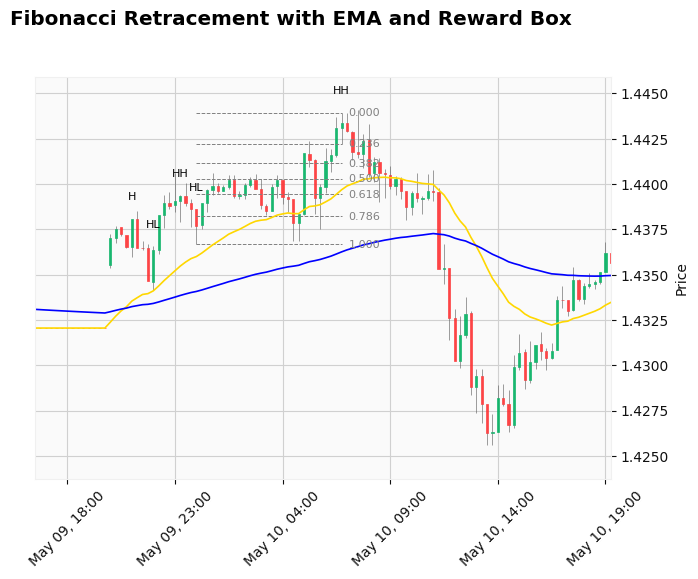

In [ ]:
import matplotlib.pyplot as plt

class BearishFSM: # Finite State Machine
    def __init__(self, df):
        self.df = df
        self.state = "IDLE"
        self.low_price = None
        
        self.low_price_idx = None
        self.high_price = None
        self.high_price_idx = None
    
        self.fib_labels = []
        self.fib_dict = {} # not a must to initialize, just for good habit
        self.entry_signal_idx = None
        self.engulfing_candle_idx = None
        self.trend_changing_idx = 3
        self.stop_loss_price = None
        self.take_profit_price = None

    def update(self, idx):

        if idx < 3:
            return
        
        trend = self.df['trend'].values
        greens = self.df["Green"]
        opens = self.df["Open"].values
        closes = self.df["Close"].values
        highs = self.df["High"].values
        lows = self.df["Low"].values
        lowest_body_price = np.select([greens == True, greens == False], [opens, closes], default= np.inf) # array-based logic, avoid direct truthiness check
        highest_body_price = np.select([greens == True, greens == False], [closes, opens], default= -np.inf) # default=np.nan ensures that rows where "Green" is missing won't cause errors
        
        current_trend = trend[idx]
        prev_trend = trend[idx - 1]

        if current_trend != prev_trend:
            self.reset()
            self.trend_changing_idx = idx
            print(f"[{self.df.index[idx]}] Trend changed from {prev_trend} to {current_trend}, reset state to IDLE")
            print("self.trend_changing_idx", idx)

        if current_trend == "bearish":
            if self.state == "IDLE":
                if self.check_pullback(greens, opens, closes, idx, "bearish"): # pullback should eat and cover the previous red candle
                    self.low_price = lowest_body_price[self.trend_changing_idx:idx+1].min()
                    self.low_price_idx = (self.trend_changing_idx) + np.argmin(
                                            lowest_body_price[self.trend_changing_idx:idx+1])
                    prev_state = self.state
                    self.df.loc[self.df.index[self.low_price_idx], "label"] = 'L'
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{self.df.index[idx]}] State changed: {prev_state} → {self.state}")

            elif self.state == "PULLBACK_DETECTED":
                if lowest_body_price[idx] < self.low_price:

                    self.high_price = highest_body_price[self.low_price_idx:idx].max()
                    self.high_price_idx = self.low_price_idx + np.argmax(highest_body_price[self.low_price_idx:idx])

                    # Identify Lower High
                    self.df.loc[self.df.index[self.high_price_idx], "label"] = 'LH'

                    prev_state = self.state
                    self.state = "BREAK_OF_STRUCTURE"
                    print(f"[{self.df.index[idx]}] State changed: {prev_state} → {self.state}")

            elif self.state == "BREAK_OF_STRUCTURE":
                # If price breaks the pev high (LH)
                if highest_body_price[idx] > self.high_price:

                    self.low_price = lowest_body_price[self.high_price_idx:idx].min()
                    self.low_price_idx = self.high_price_idx + np.argmin(
                        lowest_body_price[self.high_price_idx:idx])

                    # We identify the Higher Low (HL)
                    # self.df.loc[self.df.index[self.low_price_idx], "label"] = 'HL'
                    prev_state = self.state
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{self.df.index[idx]}] State changed: {prev_state} → {self.state}")

                elif self.check_pullback(greens, opens, closes, idx, "bearish"):
                    
                    if lowest_body_price[idx -2] < self.low_price: #### Change from idx to idx - 2

                        # Low price for confirming the next Lower high
                        self.low_price = lowest_body_price[idx-3:idx+1].min()
                        self.low_price_idx = (idx-3) + np.argmin(
                            lowest_body_price[idx-3:idx+1])

                        # Identify LL only if the current price is the lowest price in the fib retracement
                        if self.low_price == lowest_body_price[self.high_price_idx:idx+1].min():
                            self.df.loc[self.df.index[self.low_price_idx], "label"] = 'LL'

                        _,_,self.fib_labels = plot_fibonacci_candlestick(self.df, self.high_price_idx, self.low_price_idx, trend="bearish")
                        self.fib_dict = dict(self.fib_labels)
                        prev_state = self.state
                        self.state = "WAITING_ENTRY"
                        print(f"[{self.df.index[idx]}] State changed: {prev_state} → {self.state}")

                    elif highest_body_price[idx] >= self.low_price:
                        # bullish trend
                        # self.df.loc[self.df.index[idx], "label"] = 'HL'
                        prev_state = self.state
                        self.state = "PULLBACK_DETECTED"
                        print(f"[{self.df.index[idx]}] State changed: {prev_state} → {self.state}")

            elif self.state == "WAITING_ENTRY":
                fib_618_price = self.fib_dict.get(0.618)
                fib_000_price = self.fib_dict.get(0.000)
                if fib_618_price and highs[idx] >= fib_618_price: # price rebound back to 0.618
                    self.entry_signal_idx = idx
                    self.df.loc[self.df.index[idx], "label"] = '618'
                    plot_fibonacci_candlestick(self.df, self.high_price_idx, self.low_price_idx, trend="bearish", entry_signal=self.entry_signal_idx)
                    prev_state = self.state
                    self.state = "ENTRY_SIGNAL"
                    print(f"[{self.df.index[idx]}] State changed: {prev_state} → {self.state}")

                elif fib_618_price and lowest_body_price[idx] <= fib_000_price: # price lower than 0.000
                    # # break of structure, set new high point
                    self.high_price = highest_body_price[self.low_price_idx:idx].max()
                    self.high_price_idx = self.low_price_idx + np.argmax(
                        highest_body_price[self.low_price_idx:idx])

                    # Identify new "LH"
                    self.df.loc[self.df.index[self.high_price_idx], "label"] = 'LH'
                    prev_state = self.state
                    self.state = "BREAK_OF_STRUCTURE"
                    print(f"[{self.df.index[idx]}] State changed: {prev_state} → {self.state}")
            
            elif self.state == "ENTRY_SIGNAL": 
                fib_100_price = self.fib_dict.get(1.000)
                fib_000_price = self.fib_dict.get(0.000)

                if highest_body_price[idx] >= fib_100_price: # no matter what, if the candle pass 1.00, we do not trade
                    prev_state = self.state
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{self.df.index[idx]}] State changed: {prev_state} → {self.state}")

                # Bearish Engulfing candle ( the candle can break 0.00 and we still trade)
                elif (greens.iloc[idx - 1] is True) and (greens.iloc[idx] is not True) and opens[idx] > closes[idx - 1] and closes[idx] < opens[idx - 1]: # current red , prev green candle, current open > prev close, current close < prev open
                    self.engulfing_candle_idx = idx
                    self.df.loc[self.df.index[idx], "label"] = 'IN'
                    self.stop_loss_price, self.take_profit_price,_ = plot_fibonacci_candlestick(
                    self.df, self.high_price_idx, self.low_price_idx, trend="bearish",
                    entry_signal=self.entry_signal_idx, engulfing_candle=self.engulfing_candle_idx, R=2.1, pip_size=0.0075
                )
                    prev_state = self.state
                    self.state = "ENTER_MARKET"
                    print(f"[{self.df.index[idx]}] State changed: {prev_state} → {self.state}")
                    
                elif lowest_body_price[idx] <= fib_000_price: # If candle breaks 0.00 before there is a Bearish ENGULFING candle
                    prev_state = self.state
                    self.state = "BREAK_OF_STRUCTURE"
                    print(f"[{self.df.index[idx]}] State changed: {prev_state} → {self.state}")

            elif self.state == "ENTER_MARKET":
                current_high = self.df['High'].iloc[idx]
                current_low = self.df["Low"].iloc[idx]
                hit = None

                if current_high >= self.stop_loss_price:
                    hit = "STOP LOSS"
                elif current_low <= self.take_profit_price:
                    hit = "TAKE PROFIT"

                if hit is not None:
                    # Plot the box on each bar until hit
                    plot_fibonacci_candlestick(
                        self.df, self.high_price_idx, self.low_price_idx,
                        trend="bearish",
                        entry_signal=self.entry_signal_idx,
                        engulfing_candle=self.engulfing_candle_idx,
                        R=2.1,
                        pip_size=0.0075,
                        plot_until_idx=idx
                    )
                    print(f"[{self.df.index[idx]}] {hit} triggered at price {current_high if hit == 'STOP LOSS' else current_low}")
                    self.reset()
                    print(f"[{self.df.index[idx]}] Exited ENTER_MARKET — resetting FSM to IDLE")

        # ==============================================================
        # ========================  BULLISH  ============================
        # ==============================================================

        if current_trend == "bullish":
            if self.state == "IDLE":    
                if self.check_pullback(greens, opens, closes, idx, "bullish"):
                    self.high_price = highest_body_price[self.trend_changing_idx:idx+1].max()
                    self.high_price_idx = self.trend_changing_idx + np.argmax(highest_body_price[self.trend_changing_idx : idx+1])
                    self.df.loc[self.df.index[self.high_price_idx], "label"] = "H"
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{self.df.index[idx]}] State: IDLE → PULLBACK_DETECTED (bull)")

            elif self.state == "PULLBACK_DETECTED":
                if highest_body_price[idx] > self.high_price:
                    self.low_price = lowest_body_price[self.high_price_idx: idx].min()
                    self.low_price_idx = self.high_price_idx + np.argmin(lowest_body_price[self.high_price_idx:idx])

                    # Identify Higher Low
                    self.df.loc[self.df.index[self.low_price_idx], "label"] = "HL"

                    self.state = "BREAK_OF_STRUCTURE" 
                    print(f"[{self.df.index[idx]}] State: PULLBACK_DETECTED → BREAK_OF_STRUCTURE (bull)")

            elif self.state == "BREAK_OF_STRUCTURE":
                # structure broken downward -> restart pull-back search
                if lowest_body_price[idx] < self.low_price:
                    self.high_price = highest_body_price[self.low_price_idx:idx].max()
                    self.high_price_idx = self.low_price_idx + np.argmax(highest_body_price[self.low_price_idx:idx])
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{self.df.index[idx]}] State: BREAK_OF_STRUCTURE → PULLBACK_DETECTED (bull)")

                # new 3 red pull-back -> possible Fib leg
                elif self.check_pullback(greens, opens, closes, idx, "bullish"):
                    
                    if highest_body_price[idx - 2] > self.high_price: # fresh HH
                        self.high_price = highest_body_price[idx-3: idx+1].max()
                        self.high_price_idx = (idx-3) + np.argmax(highest_body_price[idx-3:idx+1])
                        print(f"self.df.index[self.high_price_idx]: {self.df.index[self.high_price_idx]}")
                        # print(f"highest_body_price[self.low_price_idx:idx]: {highest_body_price[self.low_price_idx:idx]}")
                        # Identify HH only if the current price is the highest among the fib retracement
                        if self.high_price == highest_body_price[self.low_price_idx:idx+1].max():
                            self.df.loc[self.df.index[self.high_price_idx], "label"] = "HH"

                        _,_, self.fib_labels = plot_fibonacci_candlestick(self.df, self.low_price_idx, self.high_price_idx, trend="bullish")
                        self.fib_dict = dict(self.fib_labels)
                        self.state = "WAITING_ENTRY"
                        print(f"[{self.df.index[idx]}] State: BREAK_OF_STRUCTURE → WAITING_ENTRY (bull)")

                    # price failed to beat prev high: treat as new pull-back
                    elif lowest_body_price[idx] <= self.high_price:
                        self.state = "PULLBACK_DETECTED"
                        print(f"[{self.df.index[idx]}] State: BREAK_OF_STRUCTURE → PULLBACK_DETECTED (bull)")

            elif self.state == "WAITING_ENTRY":
                fib_618_bullish = self.fib_dict.get(0.618)
                fib_000_bullish = self.fib_dict.get(0.000)

                # price retraced to 0.618 – ready for bullish entry
                if fib_618_bullish and lows[idx] <= fib_618_bullish: # count the tip of the candlestick instead of the body
                    self.entry_signal_idx = idx
                    self.df.loc[self.df.index[idx], "label"] = "618B"
                    plot_fibonacci_candlestick(self.df, self.low_price_idx,
                                               self.high_price_idx,
                                               trend="bullish", entry_signal=self.entry_signal_idx)
                    self.state = "ENTRY_SIGNAL"
                    print(f"[{self.df.index[idx]}] State: WAITING_ENTRY → ENTRY_SIGNAL (bull)")

                # price breaks above 0.000 (HH) before touching 0.618
                elif fib_618_bullish and highest_body_price[idx] > fib_000_bullish:
                    self.low_price = lowest_body_price[self.high_price_idx:idx].min()
                    self.low_price_idx = self.high_price_idx + np.argmin(lowest_body_price[self.high_price_idx:idx])
                    self.df.loc[self.df.index[self.low_price_idx], "label"] = "HL"
                    self.state = "BREAK_OF_STRUCTURE"
                    print(f"[{self.df.index[idx]}] State: WAITING_ENTRY → BREAK_OF_STRUCTURE (bull)")
                
            elif self.state == "ENTRY_SIGNAL":
                fib_100_bullish = self.fib_dict.get(1.000)
                fib_000_bullish = self.fib_dict.get(0.000)

                # cancel if price dumps below 1.000 extension
                if lowest_body_price[idx] <= fib_100_bullish:
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{self.df.index[idx]}] State: ENTRY_SIGNAL → PULLBACK_DETECTED (bull)")

                # Bullish Engulfing candle
                elif ((greens.iloc[idx-1] is not True) and (greens.iloc[idx] is True) and (opens[idx] <= closes[idx - 1]) and (closes[idx] >= opens[idx - 1])):
                    self.engulfing_candle_idx = idx
                    self.df.loc[self.df.index[idx], "label"] = "IN"
                    self.stop_loss_price, self.take_profit_price,_ = plot_fibonacci_candlestick(self.df, self.low_price_idx, self.high_price_idx,
                    trend="bullish", entry_signal=self.entry_signal_idx,
                    engulfing_candle=self.engulfing_candle_idx, R=2.1, pip_size=0.0075)
                    self.state = "ENTER_MARKET"
                    print(f"[{self.df.index[idx]}] State: ENTRY_SIGNAL → ENTER_MARKET (bull)")

                # invalidated if price breaks above HH first
                elif highest_body_price[idx] >= fib_000_bullish:
                    self.state = "BREAK_OF_STRUCTURE"
                    print(f"[{self.df.index[idx]}] State: ENTRY_SIGNAL → BREAK_OF_STRUCTURE (bull)")

            elif self.state == "ENTER_MARKET":
                current_high = self.df['High'].iloc[idx]
                current_low = self.df["Low"].iloc[idx]
                hit = None

                if current_high >= self.take_profit_price:
                    hit = "TAKE PROFIT"
                elif current_low <= self.stop_loss_price:
                    hit = "STOP LOSS"

                if hit is not None:
                    # Plot the box on each bar until hit
                    plot_fibonacci_candlestick(
                        self.df, self.low_price_idx, self.high_price_idx,
                        trend="bullish",
                        entry_signal=self.entry_signal_idx,
                        engulfing_candle=self.engulfing_candle_idx,
                        R=2.1,
                        pip_size=0.0075,
                        plot_until_idx=idx
                    )
                    print(f"[{self.df.index[idx]}] {hit} triggered at price {current_low if hit == 'STOP LOSS' else current_high}")
                    self.reset()
                    print(f"[{self.df.index[idx]}] ENTER_MARKET completed – FSM reset (bull)")


    def check_pullback(self,greens, opens, closes, idx, trend):
        if trend == "bearish":
            # Check for 3, 4, 5, or 6 consecutive green candles.
            for window in [3, 4, 5, 6]:
                start_idx = idx - window + 1
                prev_idx = start_idx - 1
                # Boundary check
                if prev_idx < 0:
                    continue
                # Check if all are green
                if all(greens.iloc[idx - i] is True for i in range(window)):
                    # Previous candle must be red
                    if greens.iloc[prev_idx] is False:
                        # Any green candle closes above the open of previous red candle
                        if any(closes[i] >= opens[prev_idx] for i in range(start_idx, idx + 1)):
                            return True
            return False
        
        if trend == "bullish":
            for window in [3,4,5,6]:
                start_idx = idx - window + 1
                prev_idx = start_idx - 1
                if prev_idx < 0:
                    continue
                if all(greens.iloc[idx - i] is not True for i in range(window)): # all previous not green candles 
                    if greens.iloc[prev_idx] is True:
                        if any(closes[i] <= opens[prev_idx] for i in range(start_idx, idx + 1)):
                            return True
            return False



    def reset(self):
        self.state = "IDLE"
        self.low_price  = self.low_price_idx  =  None
        self.high_price = self.high_price_idx =  None
        self.fib_labels = []
        self.fib_dict = {} 
        self.entry_signal_idx = None
        self.engulfing_candle_idx = None
        self.stop_loss_price = None
        self.take_profit_price = None


fsm = BearishFSM(df_4h.copy())
for idx in range(3, len(df_4h)):
    fsm.update(idx)

